<a href="https://colab.research.google.com/github/Olubusolami-R/gaussian-processes-cw/blob/main/2526/cw1/coursework1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
# Ensure correct environment for GPy
import numpy, os, signal
if numpy.__version__ != "1.26.4":
    # 1. Uninstall conflicting packages
    !pip uninstall -y jax scipy jaxlib paramz pytensor > /dev/null 2>&1
    # 2. Install the versions required for GPy
    !pip install --force-reinstall numpy==1.26.4 scipy GPy paramz > /dev/null 2>&1
    # 3. Restart runtime to load correct NumPy ABI
    os.kill(os.getpid(), signal.SIGKILL)

!wget -q https://mlg.eng.cam.ac.uk/teaching/4f13/2526/cw/cw1a.mat > /dev/null
!wget -q https://mlg.eng.cam.ac.uk/teaching/4f13/2526/cw/cw1e.mat > /dev/null
!wget -q https://raw.githubusercontent.com/cambridge-mlg/4f13-courseworks/refs/heads/main/2526/cw1/gp.py > /dev/null

In [52]:
import GPy
import numpy as np
import gp as cw1utils

In [53]:
### Arbitrary data, X and y
X = np.random.rand(20, 1) * 10  # 20 data points in 1D
y = np.sin(X) + (np.cos(X))**2 + np.random.randn(20, 1) * 0.5  # noisy opipbservations

## Loading Matlab arrays in Python

In [54]:
import scipy.io as sio

In [55]:
data = sio.loadmat("cw1a.mat")  # Note this will throw an error because the file does not exist!

X = np.asarray(data["x"], dtype=float)
y = np.asarray(data["y"], dtype=float)

## GP Model Definition with Various Kernels (using GPy):

### Single kernels

Squared exponential (SE) isotropic

In [56]:
k = GPy.kern.RBF(input_dim=X.shape[1], lengthscale=1.0, variance=1.0)
m = GPy.models.GPRegression(X, y, k)
m.likelihood.variance = 1.0  # Note that this is the default value, so we don't strictly need to set it here unless we want a different initial value.

Periodic

In [57]:
k = GPy.kern.StdPeriodic(input_dim=X.shape[1], lengthscale=1.0, period=1.0, variance=1.0)
m = GPy.models.GPRegression(X, y, k)

SE Automatic Relevance Determination (ARD)

In [58]:
k = GPy.kern.RBF(input_dim=X.shape[1], ARD=True, lengthscale=1.0, variance=1.0)
m = GPy.models.GPRegression(X, y, k)

### Combined kernels

Product of Periodic and SE Isotropic

In [59]:
k_per = GPy.kern.StdPeriodic(input_dim=X.shape[1], lengthscale=1.0, period=1.0, variance=1.0)
k_se  = GPy.kern.RBF(input_dim=X.shape[1], lengthscale=1.0, variance=1.0)
kernel = k_per * k_se
m = GPy.models.GPRegression(X, y, kernel)

Sum of two SE ARD Kernels

In [60]:
z = np.random.randn(4)
ell1 = np.exp(z[0])
sf1  = np.exp(z[1])
var1 = sf1**2

ell2 = np.exp(z[2])
sf2  = np.exp(z[3])
var2 = sf2**2

k1 = GPy.kern.RBF(input_dim=X.shape[1], ARD=True, lengthscale=ell1, variance=var1)
k2 = GPy.kern.RBF(input_dim=X.shape[1], ARD=True, lengthscale=ell2, variance=var2)
k  = k1 + k2

m = GPy.models.GPRegression(X, y, kernel=k)

## GP Model Hyperparameter Optimisation using Marginal Likelihood

Once a GP regression model is specified, we can optimise its hyperparameters by minimising the negative log marginal likelihood (which is equivalent to maximising the likelihood of the data under the model.)

In [61]:
m.optimize(optimizer='lbfgsb', max_iters=2000, messages=False)

## Utilities functions useful for producing figures to be included in report

MODEL SUMMARY
NEGATIVE LOG MARGINAL LIKELIHOOD: 78.2203
OPTIMISED HYPERPARAMETERS:
    Component 1:
      • lengthscale (ℓ): 8.80976
      • signal std (σ_f): 0.477018
    Component 2:
      • lengthscale (ℓ): 7.64811
      • signal std (σ_f): 0.508952
    Noise std (σ_n): 0.663112
LML: -78.220346
  • Data fit term: -37.497984
  • Complexity penalty: -28.198028
  • Constant term: -68.920390


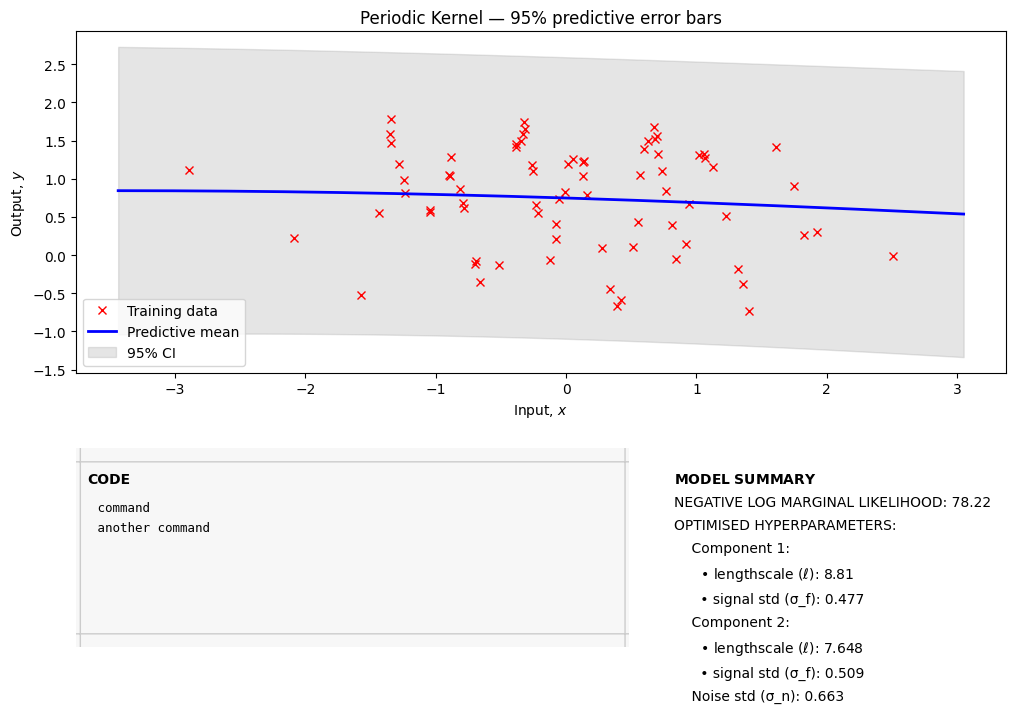

In [62]:
cw1utils.print_model_summary(m)
cw1utils.print_model_marginal_likelihood(m)
cw1utils.plot_predictive_error_bars(m, X, y, "\n command\n another command")

# cw1utils.plot_2d_predictive(mA, mB, codeA=None, codeB=None, save_path=None)
# cw1utils.plot_sampled_functions(X, F, code_snippet, n_draws=3, save_path=None)

# Now to the questions

## Question A

In [63]:
# loading the data

data = sio.loadmat("cw1a.mat")

X = np.asarray(data["x"], dtype=float)
y = np.asarray(data["y"], dtype=float)

#  Train a GP with a squared exponential covariance function, GPy.kern.RBF() and intialise the hyper parameters as described.

k = GPy.kern.RBF(input_dim=X.shape[1], lengthscale=np.exp(-1.0), variance=1.0)
m = GPy.models.GPRegression(X, y, k)

m.Gaussian_noise.variance = 1.0

In [64]:
m.optimize()

In [65]:
print(m)


Name : GP regression
Objective : 11.899004246684939
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |    0.8045956274095476  |      +ve      |        
  rbf.lengthscale          |   0.12822652660430478  |      +ve      |        
  Gaussian_noise.variance  |  0.013883389223900876  |      +ve      |        


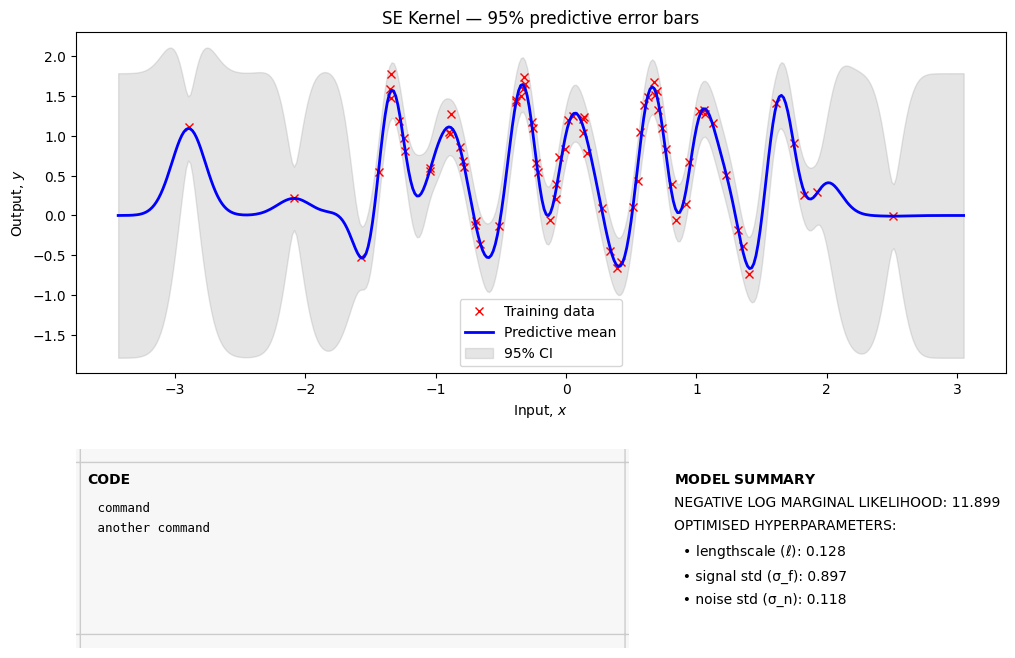

In [66]:
cw1utils.plot_predictive_error_bars(m, X, y, "\n command\n another command")

# Some preliminary observations for this part a

Analysing the optimised params:
---

- lengthscale: This is a very small value relative to the input range.
- The model now assumes points only a small distance apart are highly correlated. This allows the model to produce a highly oscillating or "wiggly" function that accurately tracks the rapid variations in the data.
- Low noise estimate: The model believes the data is relatively clean and the wiggles are true signal, not just noise. It therefore attempts to pass very closely to the majority of the data points.
- This value (variance $\sigma_f^2 \approx 0.805$) is close to the vertical range of the wiggles.Consequence: It confirms the magnitude of the smooth variations that the function makes.

- Narrow Bands Near Data (Interpolation): The shaded area is tightly constrained around the predictive mean (blue line) where the training data (red crosses) exists. This narrowness is due to the low noise estimate ($\sigma_n \approx 0.118$), showing high confidence in the function's value near observed points.
- The small optimized lengthscale ($\ell=0.128$) implies that the function must be highly wiggly. This is clearly demonstrated by the predictive error bars, which are extremely narrow directly around the data points (due to the low noise $\sigma_n$), but rapidly widen in any region devoid of data (e.g., $x \approx -2.5$ and $x>2.0$), because the model instantly loses correlation just a short distance away from the observations.
- Uncertainty Spikes in Extrapolation: In the regions far outside the data (e.g., $x>2.5$ or $x<-3.0$), the uncertainty quickly reaches the maximum level defined by the Signal Standard Deviation, confirming the model has no idea what happens far outside the training range.


# Mental Cheatsheet
- **Lengthscale (l)**: small value - wiggly fxn, quickly changing. High value - Smooth function, slow to change. low l is typically less than input range. high l is higher than input range.

- **Noise Variance ($\sigma_n^2$) (The Cleanliness Measure):** The Noise Variance is compared to the Signal Variance ($\sigma_f^2$) itself, as it defines the signal-to-noise ratio. Low $\sigma_n^2$ that is $\sigma_n^2 \ll \sigma_f^2$ means *the data is believed to be clean*. The model trusts the data points and tries to fit them tightly, resulting in narrow error bars at the data points. For $\sigma_n^2 \approx \sigma_f^2$ or $\sigma_n^2 > \sigma_f^2$, The data is believed to be noisy. The model is forced to smooth over the points, and the uncertainty remains high everywhere. *In summary, if low, data is clean; model fits points tightly. If high, data is noisy; model smooths over the points.*

- **Signal variance**: If it is low, function is flat. If it is high, function has large vertical swings.

## Question B


In [67]:
#Testing different hyperparameter values

k_B = GPy.kern.RBF(input_dim=X.shape[1], variance=1.0, lengthscale=1000.0)


mB = GPy.models.GPRegression(X, y, k_B)


mB.Gaussian_noise.variance = 1000.0


mB.optimize()

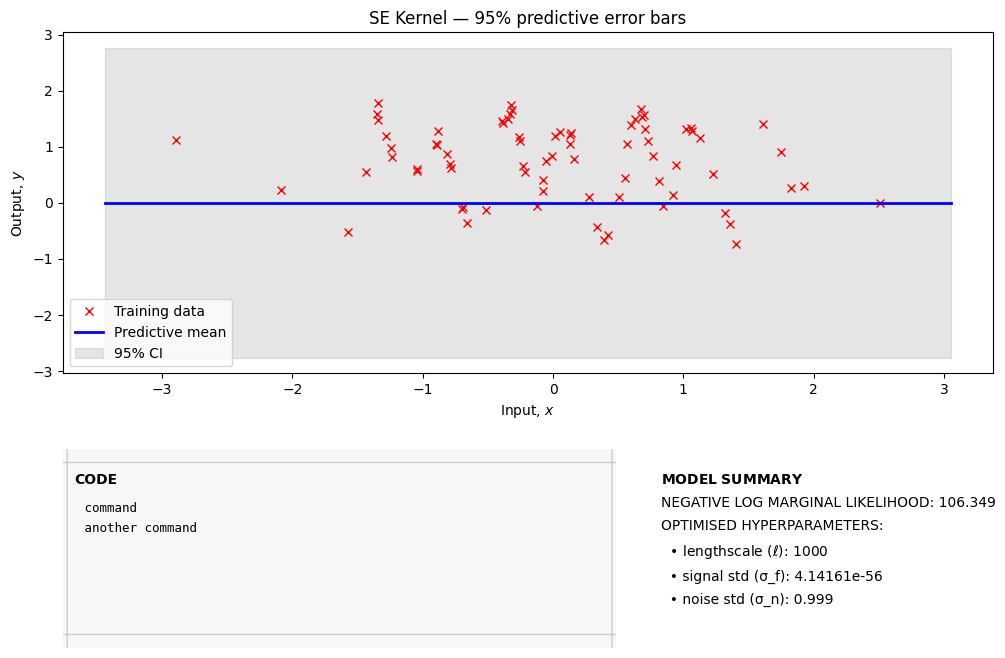

In [68]:
cw1utils.plot_predictive_error_bars(mB, X, y, "\n command\n another command")

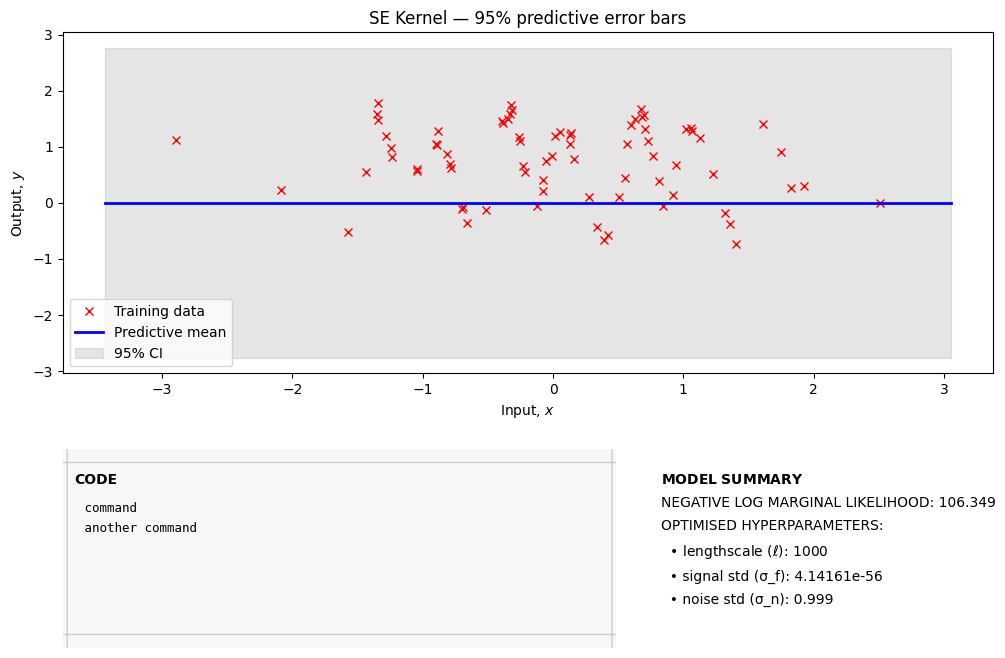

In [69]:
# another model

k_C = GPy.kern.RBF(input_dim=X.shape[1], variance=1.0, lengthscale=0.001)


mC = GPy.models.GPRegression(X, y, k_C)


mC.Gaussian_noise.variance = 0.001


mC.optimize()
cw1utils.plot_predictive_error_bars(mB, X, y, "\n command\n another command")